## Data Augmentation

### Check GPU Type

In [ ]:
!nvidia-smi

Wed Sep 27 09:17:09 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 528.24       Driver Version: 528.24       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  Off |
|  0%   39C    P8     8W / 450W |  12602MiB / 24564MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Import Packages

In [ ]:
_exp_name = "CTSlice"

In [ ]:
# Import necessary packages.
import numpy as np
import pandas as pd
import torch
import os
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
# "ConcatDataset" and "Subset" are possibly useful when doing semi-supervised learning.
from torch.utils.data import ConcatDataset, DataLoader, Subset, Dataset
from torchvision.datasets import DatasetFolder, VisionDataset
# This is for the progress bar.
from tqdm.auto import tqdm
import random
from random import shuffle

# cache
from functools import lru_cache

In [ ]:
myseed = 6666  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
#This flag allows you to enable the inbuilt cudnn auto-tuner to find the best algorithm to use for your hardware.
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

### Datasets

In [ ]:
class DADataset(Dataset):
    def __init__(self, path, part, files=None):
        super(DADataset, self).__init__()
        self.path = path
        self.files = sorted([os.path.join(path, x) for x in os.listdir(path)])
        random.seed(8)  # Use random.seed to ensure reproducibility
        random.shuffle(self.files)
        total_files = len(self.files)
        cutTrain = total_files // 10 * 8
        cutTest = total_files // 10 * 9
        if part == "train":
            self.files = self.files[:cutTrain]
        elif part == "val":
            self.files = self.files[cutTrain:cutTest]
        elif part == "test":
            self.files = self.files[cutTest:]
        else:
            raise ValueError("Invalid part. Must be 'train', 'val', or 'test'.")
        if files is not None:
            self.files = files

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        fname = self.files[idx]

        # Split the string using the underscore as a delimiter
        pid = fname.split("\\")[-1].split("_")[-2]
        slice_num = int(fname.split("\\")[-1].split("_")[-1])
        im = torch.from_numpy(np.load(fname + "/train.npy")).float()
        label = torch.from_numpy(np.load(fname + "/val.npy")).float()

        return pid, slice_num, im, label

### Model

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.down_conv1 = self.double_conv(4, 64)
        self.down_conv2 = self.double_conv(64, 128)
        self.down_conv3 = self.double_conv(128, 256)
        self.down_conv4 = self.double_conv(256, 512)
        self.up_conv1 = self.double_conv(512 + 256, 256)
        self.up_conv2 = self.double_conv(256 + 128, 128)
        self.up_conv3 = self.double_conv(128 + 64, 64)
        self.up_conv4 = nn.Conv2d(64, 1, kernel_size=1)
        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Downward path
        x1 = self.down_conv1(x)
        x2 = self.maxpool(x1)
        x3 = self.down_conv2(x2)
        x4 = self.maxpool(x3)
        x5 = self.down_conv3(x4)
        x6 = self.maxpool(x5)
        x7 = self.down_conv4(x6)

        # Upward path
        x = self.upsample(x7)
        x = torch.cat([x, x5], dim=1)
        x = self.up_conv1(x)
        x = self.upsample(x)
        x = torch.cat([x, x3], dim=1)
        x = self.up_conv2(x)
        x = self.upsample(x)
        x = torch.cat([x, x1], dim=1)
        x = self.up_conv3(x)
        x = self.up_conv4(x)

        return x

### Configurations

In [ ]:
# "cuda" only when GPUs are available.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize a model and put it on the specified device.
model = UNet().to(device)

# The number of batch size.
batch_size = 10

# The number of training epochs.
n_epochs = 30

# If no improvement in 'patience' epochs, early stop.
patience = 10

# For the classification task, we use mean squared error as the measurement of performance.
criterion = nn.MSELoss()

# Initialize optimizer. You may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

### Dataloader for test

In [ ]:
# Construct test datasets.
# The argument "loader" tells how torchvision reads the data.

test_set =  DADataset("../Luna16_data/split4_data", "test")
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

### Testing

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
model_best = UNet().to(device)
model_best.load_state_dict(torch.load(f"{_exp_name}_best.ckpt"))
model_best.eval()

# Initialize variables to store evaluation metrics
mae_total = 0.0
mse_total = 0.0
iou_total = 0.0
dice_total = 0.0
num_samples = 0

with torch.no_grad():
    for pid, slice_num, data, truth in tqdm(test_loader):
        test_pred = model_best(data.to(device))

        # Convert tensors to NumPy arrays
        predict = test_pred.cpu().data.numpy().squeeze()[0]
        tru = truth.cpu().data.numpy()[0]

        # Calculate Mean Absolute Error (MAE)
        mae = np.abs(predict - tru).mean()
        mae_total += mae

        # Calculate Mean Squared Error (MSE)
        mse = ((predict - tru) ** 2).mean()
        mse_total += mse

        # Calculate Intersection over Union (IoU)
        intersection = np.logical_and(predict > 0, tru > 0)
        union = np.logical_or(predict > 0, tru > 0)
        iou = np.sum(intersection) / np.sum(union)
        iou_total += iou

        # Calculate Dice Coefficient
        dice = (2.0 * np.sum(intersection)) / (np.sum(predict > 0) + np.sum(tru > 0))
        dice_total += dice

        num_samples += 1

# Calculate the average metrics over all test samples
average_mae = mae_total / num_samples
average_mse = mse_total / num_samples
average_iou = iou_total / num_samples
average_dice = dice_total / num_samples

print(f"Average MAE: {average_mae}")
print(f"Average MSE: {average_mse}")
print(f"Average IoU: {average_iou}")
print(f"Average Dice Coefficient: {average_dice}")

  0%|          | 0/2237 [00:00<?, ?it/s]

Average MAE: 25.125901976599458
Average MSE: 2909.9424250529823
Average IoU: 0.8434339026641308
Average Dice Coefficient: 0.9093154093336213


  0%|          | 0/2237 [00:00<?, ?it/s]

Predicted:


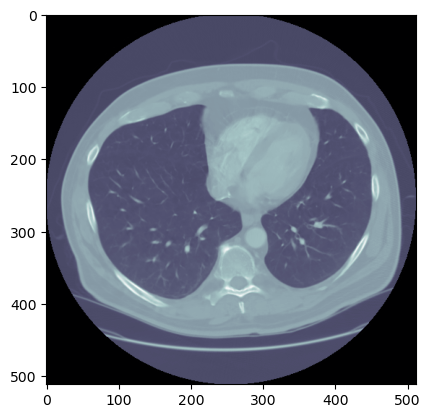

Ground Truth:


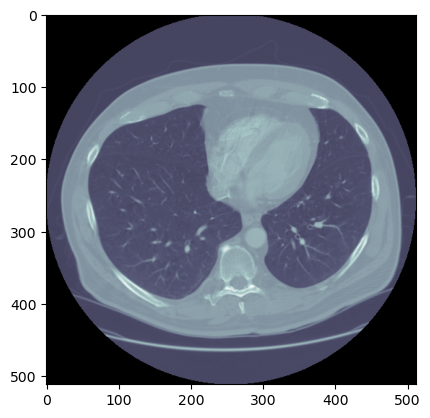

Predicted:


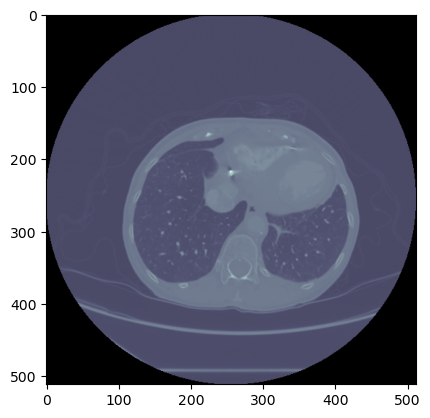

Ground Truth:


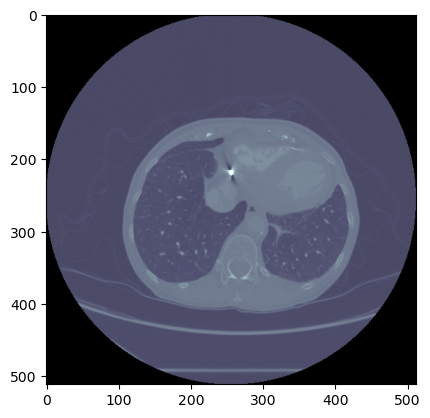

Predicted:


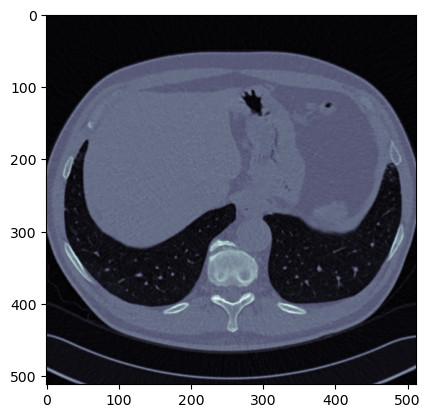

Ground Truth:


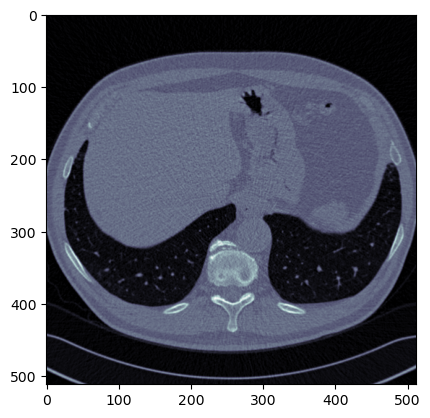

Predicted:


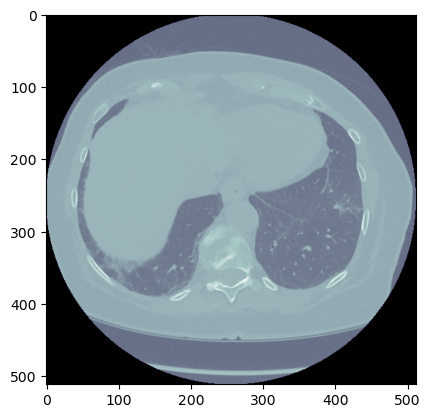

Ground Truth:


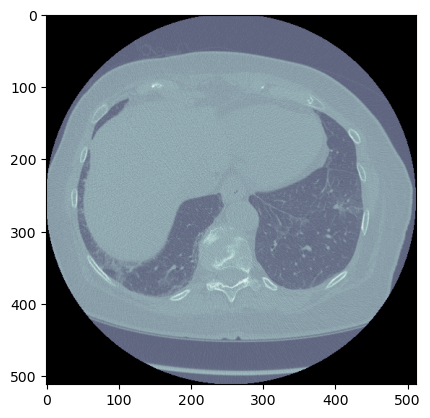

Predicted:


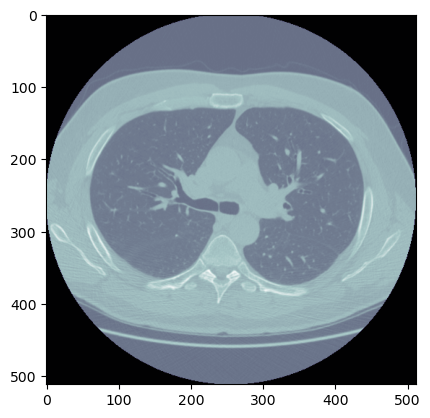

Ground Truth:


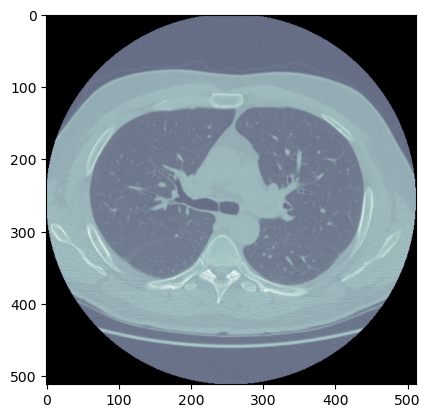

In [ ]:
model_best = UNet().to(device)
model_best.load_state_dict(torch.load(f"{_exp_name}_best.ckpt"))
model_best.eval()

# Initialize variables to store evaluation metrics
mae_total = 0.0
mse_total = 0.0
iou_total = 0.0
dice_total = 0.0
num_samples = 0

c = 0

with torch.no_grad():
    for pid, slice_num, data, truth in tqdm(test_loader):
        test_pred = model_best(data.to(device))
        # print(torch.squeeze(test_pred[0]))

        print("Predicted:")
        plt.imshow (torch.squeeze(test_pred[8]).to("cpu").numpy(), cmap = "bone")
        plt.show()
        print("Ground Truth:")
        plt.imshow (torch.squeeze(truth[8]).to("cpu").numpy(), cmap = "bone")
        plt.show()

        c += 1

        if c == 5:
            break

Mean Absolute Error (MAE):

MAE measures the absolute difference between the predicted and ground truth values on a per-pixel/voxel basis.
A lower MAE indicates better accuracy.
Benchmark: MAE values typically range from 0 to a few units (e.g., 0 to 5 HU for CT images).

Mean Squared Error (MSE):
MSE measures the squared difference between predicted and ground truth values on a per-pixel/voxel basis.
A lower MSE indicates better accuracy.
Benchmark: MSE values typically range from 0 to a few tens (e.g., 0 to 100) for HU values.

Intersection over Union (IoU):
IoU measures the overlap between the predicted and ground truth binary masks.
It ranges from 0 (no overlap) to 1 (perfect overlap).
Benchmark: IoU values above 0.7 are generally considered good for medical image segmentation.

Dice Coefficient:
The Dice Coefficient also measures the overlap between the predicted and ground truth binary masks.
It ranges from 0 (no overlap) to 1 (perfect overlap).
Benchmark: Dice values above 0.7 are considered good for medical image segmentation.

### Write back